In [13]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import comcloak
try:
    print("Current directory:", os.getcwd())
    import comcloak
except ImportError as e:
    # Install comcloak if package is not already installed
    import os
    import sys
    sys.path.append("../")
    # os.system("pip install comcloak")
    import comcloak

# Load the required comcloak components
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time

from comcloak.mimo import StreamManagement

from comcloak.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer
from comcloak.ofdm import OFDMModulator, OFDMDemodulator, ZFPrecoder, RemoveNulledSubcarriers

from comcloak.channel.tr38901 import AntennaArray, CDL, Antenna
from comcloak.channel import subcarrier_frequencies, cir_to_ofdm_channel, cir_to_time_channel, time_lag_discrete_time_channel
from comcloak.channel import ApplyOFDMChannel, ApplyTimeChannel, OFDMChannel, TimeChannel

from comcloak.fec.ldpc.encoding import LDPC5GEncoder
from comcloak.fec.ldpc.decoding import LDPC5GDecoder

from comcloak.mapping import Mapper, Demapper

from comcloak.utils import BinarySource, ebnodb2no, sim_ber
from comcloak.utils.metrics import compute_ber
import tensorflow as tf
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')
# print("Available GPUs:", gpus)
# print(f"可用的GPU数量: {len(gpus)}")
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')
comcloak.config.xla_compat=False

Current directory: /home/wzs/Project/sionna-main/practical


/home/wzs/Project/sionna-main/practical/../comcloak/mapping.py:362: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._points = torch.tensor(points, dtype=get_real_dtype(self._dtype))


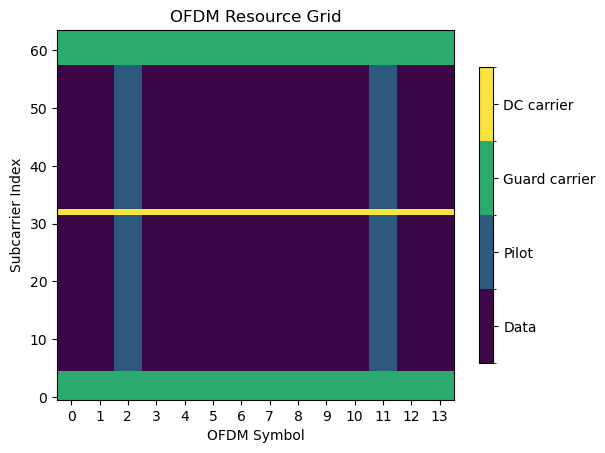

In [14]:
# Define the number of UT and BS antennas.
# For the CDL model, that will be used in this notebook, only
# a single UT and BS are supported.
num_ut = 1
num_bs = 1
num_ut_ant = 16
num_bs_ant = 16

# The number of transmitted streams is equal to the number of UT antennas
# in both uplink and downlink
num_streams_per_tx = 4

# Create an RX-TX association matrix
# rx_tx_association[i,j]=1 means that receiver i gets at least one stream
# from transmitter j. Depending on the transmission direction (uplink or downlink),
# the role of UT and BS can change. However, as we have only a single
# transmitter and receiver, this does not matter:
rx_tx_association = np.array([[1]])

# Instantiate a StreamManagement object
# This determines which data streams are determined for which receiver.
# In this simple setup, this is fairly easy. However, it can get more involved
# for simulations with many transmitters and receivers.
sm = StreamManagement(rx_tx_association, num_streams_per_tx)
rg = ResourceGrid(num_ofdm_symbols=14,
                  fft_size=64,
                  subcarrier_spacing=15e3,
                  num_tx=1,
                  num_streams_per_tx=num_streams_per_tx,
                  cyclic_prefix_length=16,
                  num_guard_carriers=[5,6],
                  dc_null=True,
                  pilot_pattern="kronecker",
                  pilot_ofdm_symbol_indices=[2,11])
rg.show();

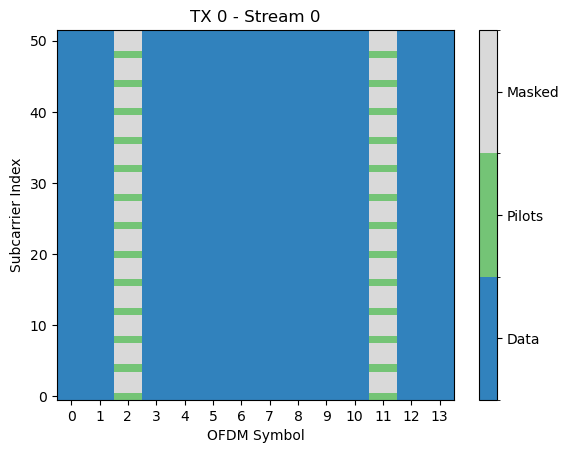

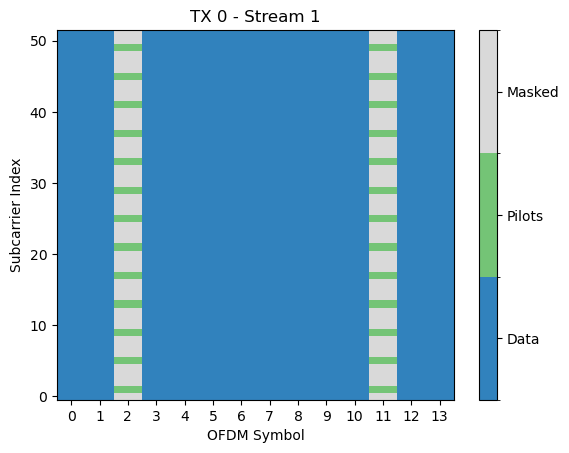

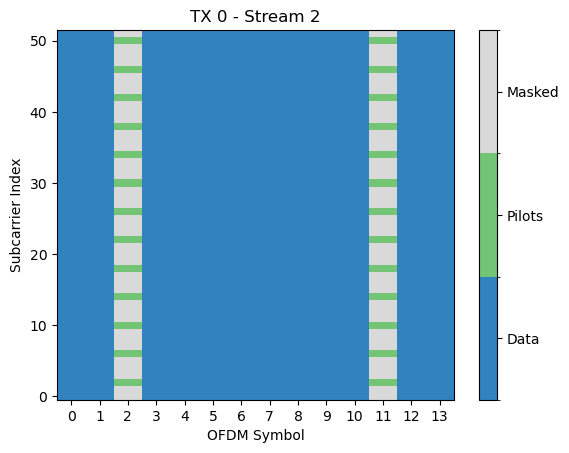

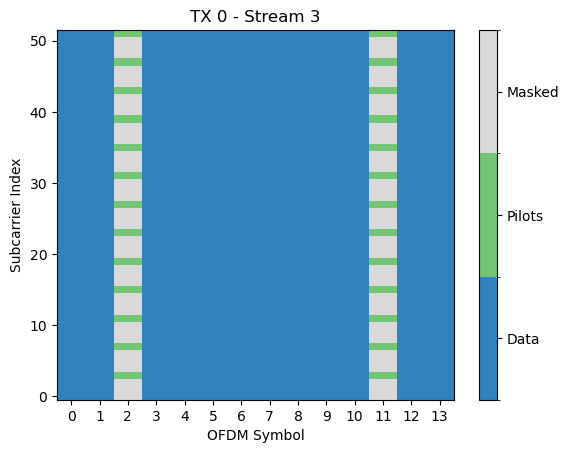

In [15]:
rg.pilot_pattern.show();

In [16]:
carrier_frequency = 2.6e9 # Carrier frequency in Hz.
                          # This is needed here to define the antenna element spacing.

ut_array = AntennaArray(num_rows=1,
                        num_cols=int(num_ut_ant/2),
                        polarization="dual",
                        polarization_type="cross",
                        antenna_pattern="38.901",
                        carrier_frequency=carrier_frequency)
# ut_array.show()

bs_array = AntennaArray(num_rows=1,
                        num_cols=int(num_bs_ant/2),
                        polarization="dual",
                        polarization_type="cross",
                        antenna_pattern="38.901",
                        carrier_frequency=carrier_frequency)
# bs_array.show()

delay_spread = 300e-9 # Nominal delay spread in [s]. Please see the CDL documentation
                      # about how to choose this value. 

direction = "downlink"  # The `direction` determines if the UT or BS is transmitting.
                      # In the `uplink`, the UT is transmitting.
cdl_model = "B"       # Suitable values are ["A", "B", "C", "D", "E"]

speed = 1            # UT speed [m/s]. BSs are always assumed to be fixed.
                      # The direction of travel will chosen randomly within the x-y plane.

# Configure a channel impulse reponse (CIR) generator for the CDL model.
# cdl() will generate CIRs that can be converted to discrete time or discrete frequency.
cdl = CDL(cdl_model, delay_spread, carrier_frequency, ut_array, bs_array, direction, min_speed=speed)
# a, tau = cdl(batch_size=8, num_time_steps=rg.num_ofdm_symbols, sampling_frequency=1/rg.ofdm_symbol_duration)

# The following values for truncation are recommended.
# Please feel free to tailor them to you needs.
l_min, l_max = time_lag_discrete_time_channel(rg.bandwidth)
l_tot = l_max-l_min+1
a, tau = cdl(batch_size=2, num_time_steps=rg.num_time_samples+l_tot-1, sampling_frequency=rg.bandwidth)

print("Shape of the path gains: ", a.shape)
print("Shape of the delays:", tau.shape)
frequencies = subcarrier_frequencies(rg.fft_size, rg.subcarrier_spacing)
h_freq = cir_to_ofdm_channel(frequencies, a, tau, normalize=True)
# Function that will apply the channel frequency response to an input signal
channel_freq = ApplyOFDMChannel(add_awgn=True)
# Function that will apply the discrete-time channel impulse response to an input signal
channel_time = ApplyTimeChannel(rg.num_time_samples, l_tot=l_tot, add_awgn=True)


/home/wzs/Project/sionna-main/practical/../comcloak/channel/utils.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  l_max = torch.tensor(l_max, dtype=torch.int32)
/home/wzs/Project/sionna-main/practical/../comcloak/channel/tr38901/channel_coefficients.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_data = torch.tensor(input_data)
/home/wzs/Project/sionna-main/practical/../comcloak/channel/tr38901/channel_coefficients.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  indices = torch.tensor(indices)


Shape of the path gains:  torch.Size([2, 1, 16, 1, 16, 23, 1135])
Shape of the delays: torch.Size([2, 1, 1, 23])


/home/wzs/Project/sionna-main/practical/../comcloak/channel/utils.py:204: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tau = torch.tensor(tau)


In [17]:
num_bits_per_symbol = 2 # QPSK modulation
coderate = 0.5 # Code rate
n = int(rg.num_data_symbols*num_bits_per_symbol) # Number of coded bits
k = int(n*coderate) # Number of information bits

# The binary source will create batches of information bits
binary_source = BinarySource()

# The encoder maps information bits to coded bits
encoder = LDPC5GEncoder(k, n)

# The mapper maps blocks of information bits to constellation symbols
mapper = Mapper("qam", num_bits_per_symbol)

# The resource grid mapper maps symbols onto an OFDM resource grid
rg_mapper = ResourceGridMapper(rg)

# The zero forcing precoder precodes the transmit stream towards the intended antennas
zf_precoder = ZFPrecoder(rg, sm, return_effective_channel=True)

# OFDM modulator and demodulator
modulator = OFDMModulator(rg.cyclic_prefix_length)
demodulator = OFDMDemodulator(rg.fft_size, l_min, rg.cyclic_prefix_length)

# This function removes nulled subcarriers from any tensor having the shape of a resource grid
remove_nulled_scs = RemoveNulledSubcarriers(rg)

# The LS channel estimator will provide channel estimates and error variances
ls_est = LSChannelEstimator(rg, interpolation_type="nn")

# The LMMSE equalizer will provide soft symbols together with noise variance estimates
lmmse_equ = LMMSEEqualizer(rg, sm)

# The demapper produces LLR for all coded bits
demapper = Demapper("app", "qam", num_bits_per_symbol)

# The decoder provides hard-decisions on the information bits
decoder = LDPC5GDecoder(encoder, hard_out=True)

/home/wzs/Project/sionna-main/practical/../comcloak/mapping.py:670: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._c0 = torch.tensor(c0, dtype=torch.int32) # Symbols with ith bit=0
/home/wzs/Project/sionna-main/practical/../comcloak/mapping.py:671: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._c1 = torch.tensor(c1, dtype=torch.int32) # Symbols with ith bit=1


In [18]:
import math
import torch    
def apply_residual_cfo(y_time, fs, delta_f, phi0=0.0, pn_std_per_sample=0.0, device=None):
    """
    Apply residual CFO (+ optional phase noise) to time-domain signal y.
    y: complex tensor shape (B, R, A, T) (dtype=torch.cfloat)
    fs: sampling rate (Hz)
    delta_f: scalar or tensor broadcastable to (B, R, A) in Hz
    phi0: initial phase in radians, scalar or broadcastable to (B,R,A)
    pn_std_per_sample: std dev of Wiener increment per sample (radians). If 0 -> no PN.
    Returns: y_out same shape as y (complex)
    """
    if device is None:
        device = y_time.device
    B, R, A, T = y_time.shape
    # time index n (0..T-1)
    n = torch.arange(T, device=device, dtype=torch.float32)  # (T,)
    # ensure delta_f and phi0 have shape (B,R,A,1) for broadcasting
    def _prep(x):
        tx = torch.as_tensor(x, device=device, dtype=torch.float32)
        while tx.dim() < 3:
            tx = tx.unsqueeze(0)
        # now tx shape <=3, expand to (B,R,A)
        tx = tx.expand(B, R, A)
        return tx.unsqueeze(-1)  # (B,R,A,1)

    delta_f_t = _prep(delta_f)    # (B,R,A,1)
    phi0_t = _prep(phi0)          # (B,R,A,1)

    # deterministic phase: 2*pi*delta_f * n / fs + phi0
    phase_det = 2.0 * math.pi * delta_f_t * (n / fs) + phi0_t  # (B,R,A,T)
    # optionally add Wiener phase noise (cumulative normal increments)
    if pn_std_per_sample > 0.0:
        # generate normal increments per sample and cumsum
        increments = torch.normal(0.0, pn_std_per_sample, size=(B, R, A, T), device=device)
        pn = torch.cumsum(increments, dim=-1)  # (B,R,A,T)
    else:
        pn = torch.zeros_like(phase_det)

    total_phase = phase_det + pn  # (B,R,A,T)
    phasor = torch.exp(1j * total_phase)  # complex phasor
    y_out = y_time * phasor
    return y_out


In [ ]:
batch_size = 1 # We pick a small batch_size as executing this code in Eager mode could consume a lot of memory
ebno_db = 20
perfect_csi = False

no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate, rg)
b = binary_source([batch_size, 1, rg.num_streams_per_tx, encoder.k])
c = encoder(b)
x = mapper(c)
print("Shape of the x: ", x.shape)
x_rg = rg_mapper(x)

cir = cdl(batch_size, rg.num_ofdm_symbols, 1/rg.ofdm_symbol_duration)
h_freq = cir_to_ofdm_channel(frequencies, *cir, normalize=True)
x_rg, g = zf_precoder([x_rg, h_freq])

# The CIR needs to be sampled every 1/bandwith [s].
# In contrast to frequency-domain modeling, this implies
# that the channel can change over the duration of a single
# OFDM symbol. We now also need to simulate more
# time steps.
cir = cdl(batch_size, rg.num_time_samples+l_tot-1, rg.bandwidth)

# OFDM modulation with cyclic prefix insertion
x_time = modulator(x_rg)
print("Shape of the x_time: ", x_time.shape)
# Compute the discrete-time channel impulse reponse
h_time = cir_to_time_channel(rg.bandwidth, *cir, l_min, l_max, normalize=True)

# Compute the channel output
# This computes the full convolution between the time-varying
# discrete-time channel impulse reponse and the discrete-time
# transmit signal. With this technique, the effects of an
# insufficiently long cyclic prefix will become visible. This
# is in contrast to frequency-domain modeling which imposes
# no inter-symbol interfernce.
y_time = channel_time([x_time, h_time, no])
# OFDM demodulation and cyclic prefix removal
print("Shape of the y_time: ", y_time.shape)
y = demodulator(y_time)
print("Shape of the y: ", y.shape)

# y = demodulator(y_time)
# print("Shape of the y: ", y.shape)
if perfect_csi:
    
    a, tau = cir
    
    # We need to sub-sample the channel impulse reponse to compute perfect CSI
    # for the receiver as it only needs one channel realization per OFDM symbol
    a_freq = a[...,rg.cyclic_prefix_length:-1:(rg.fft_size+rg.cyclic_prefix_length)]
    a_freq = a_freq[...,:rg.num_ofdm_symbols]
    
    # Compute the channel frequency response
    h_freq = cir_to_ofdm_channel(frequencies, a_freq, tau, normalize=True)
   
    h_hat, err_var = remove_nulled_scs(h_freq), 0.
else:
    h_hat, err_var = ls_est ([y, no])
print("Shape of the h_hat: ", h_hat.shape)
x_hat, no_eff = lmmse_equ([y, h_hat, err_var, no])
print("Shape of the x_hat: ", x_hat.shape)
llr = demapper([x_hat, no_eff])
b_hat = decoder(llr)
print("Shape of the llr: ", llr.shape)
print("Shape of the b_hat: ", b_hat.shape)
print("Shape of the b: ", b.shape)
ber = compute_ber(b, b_hat)
print("BER: {}".format(ber))



fft_size = 64
subcarrier_spacing = 15e3
fs = fft_size * subcarrier_spacing  # Sampling frequency
delta_f = 100.0  # Residual CFO in Hz
y_time_cfo = apply_residual_cfo(y_time, fs, delta_f, phi0=0.0, pn_std_per_sample=0.0)
y_cfo = demodulator(y_time_cfo)
h_hat, err_var = ls_est ([y_cfo, no])
x_hat_cfo, no_eff = lmmse_equ([y_cfo, h_hat, err_var, no])
llr = demapper([x_hat_cfo, no_eff])
b_hat = decoder(llr)
ber = compute_ber(b, b_hat)
print("CFO BER: {}".format(ber))

Shape of the x:  torch.Size([1, 1, 4, 624])


/home/wzs/Project/sionna-main/practical/../comcloak/ofdm/resource_grid.py:441: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  template2 = torch.tensor(template)
/home/wzs/Project/sionna-main/practical/../comcloak/channel/tr38901/channel_coefficients.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_data = torch.tensor(input_data)
/home/wzs/Project/sionna-main/practical/../comcloak/channel/tr38901/channel_coefficients.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  indices = torch.tensor(indices)
/home/wzs/Project/sionna-main/

Shape of the x_time:  torch.Size([1, 1, 16, 1120])
Shape of the y_time:  torch.Size([1, 1, 16, 1135])
Shape of the y:  torch.Size([1, 1, 16, 14, 64])
Shape of the x_hat:  torch.Size([1, 1, 4, 624])


/home/wzs/Project/sionna-main/practical/../comcloak/ofdm/channel_estimation.py:198: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  no = torch.tensor(no, device=y.device)
/home/wzs/Project/sionna-main/practical/../comcloak/ofdm/channel_estimation.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_data = torch.tensor(input_data)
/home/wzs/Project/sionna-main/practical/../comcloak/ofdm/channel_estimation.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  indices = torch.tensor(indices)
/home/wzs/Project/sionna-main/practical/../comc

Shape of the llr:  torch.Size([1, 1, 4, 1248])
Shape of the b_hat:  torch.Size([1, 1, 4, 624])
Shape of the b:  torch.Size([1, 1, 4, 624])
BER: 0.051682692307692304


/home/wzs/Project/sionna-main/practical/../comcloak/utils/metrics.py:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ber = torch.tensor(ber, dtype=torch.float64) # torch.float64 to suport large batch-sizes


CFO BER: 0.05488782051282051


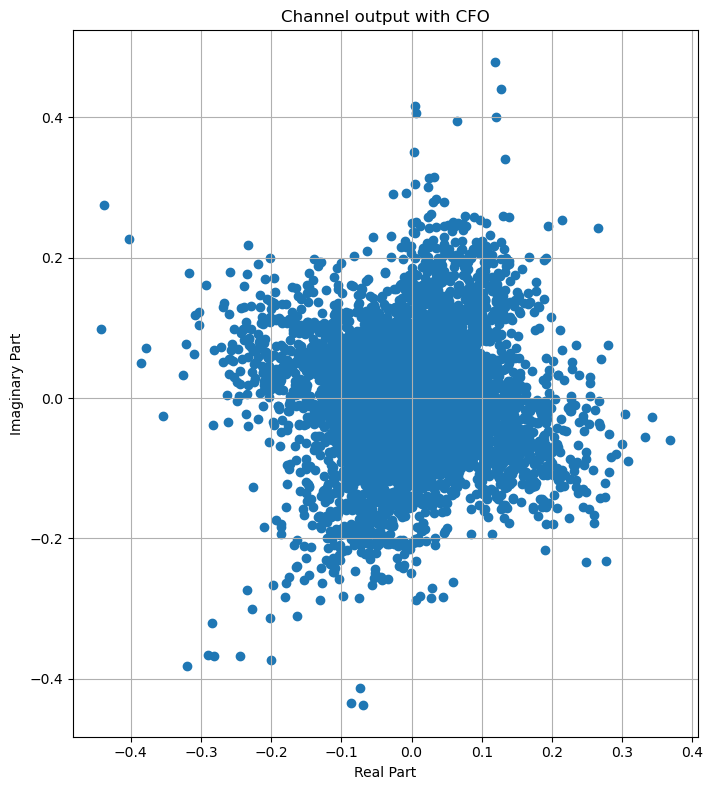

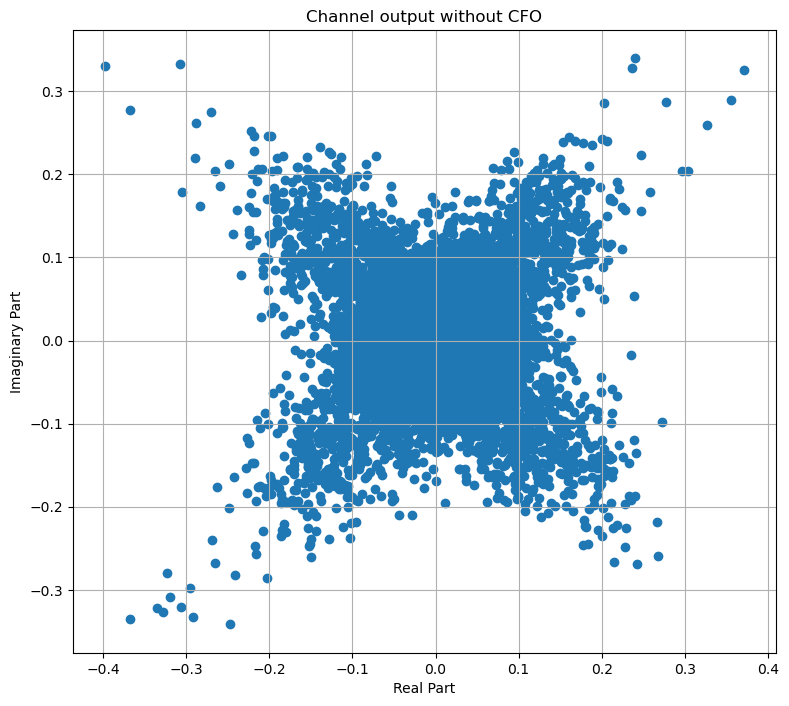

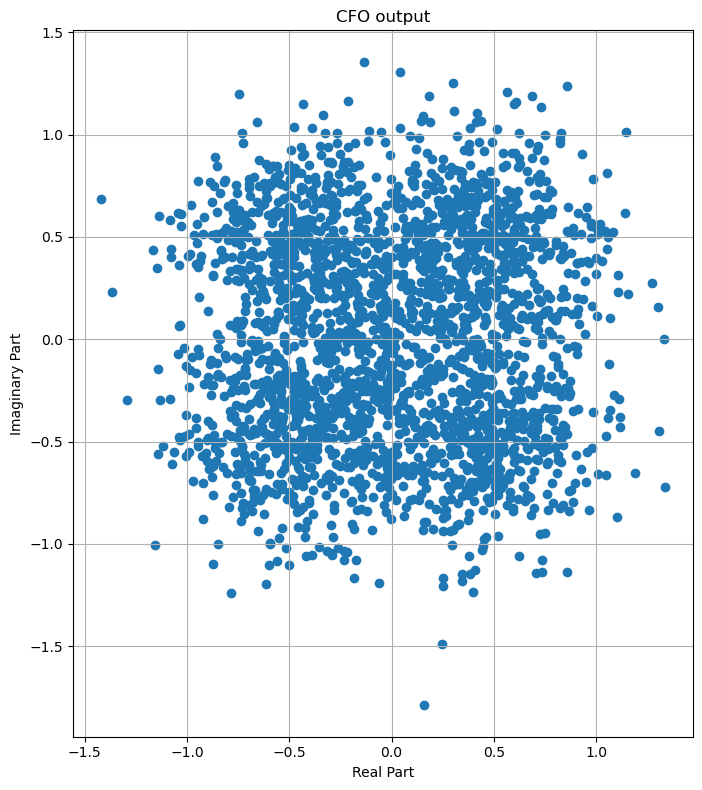

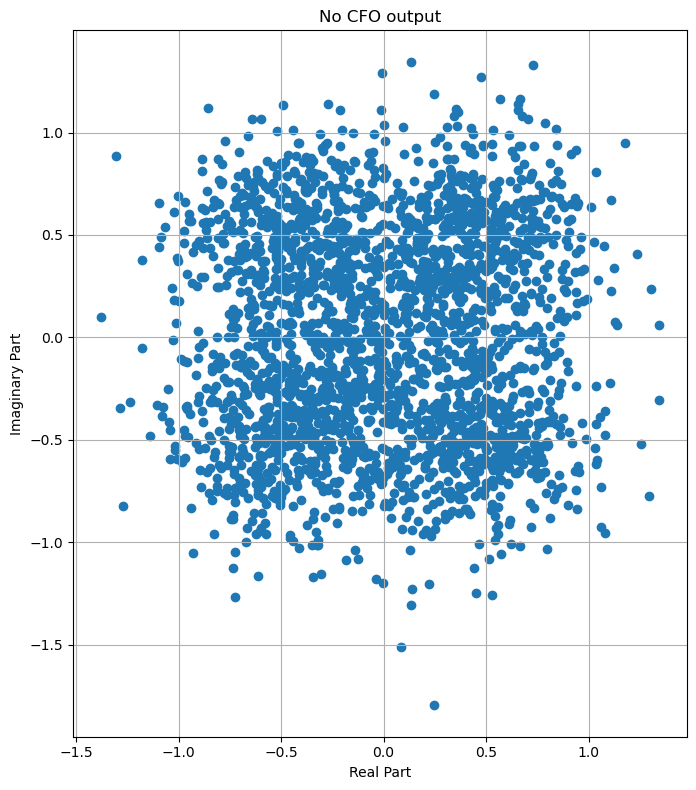

In [20]:
plt.figure(figsize=(8,8))
plt.axes().set_aspect(1)
plt.grid(True)
plt.title('Channel output with CFO')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.scatter(tf.math.real(y_cfo), tf.math.imag(y_cfo))
plt.tight_layout()

plt.figure(figsize=(8,8))
plt.axes().set_aspect(1)
plt.grid(True)
plt.title('Channel output without CFO')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.scatter(tf.math.real(y), tf.math.imag(y))
plt.tight_layout()

plt.figure(figsize=(8,8))
plt.axes().set_aspect(1)
plt.grid(True)
plt.title('CFO output')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.scatter(tf.math.real(x_hat_cfo), tf.math.imag(x_hat_cfo))
plt.tight_layout()

plt.figure(figsize=(8,8))
plt.axes().set_aspect(1)
plt.grid(True)
plt.title('No CFO output')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.scatter(tf.math.real(x_hat), tf.math.imag(x_hat))
plt.tight_layout()



In [21]:
# plt.figure(figsize=(8,8))
# plt.axes().set_aspect(1)
# plt.grid(True)
# plt.title('Original output')
# plt.xlabel('Real Part')
# plt.ylabel('Imaginary Part')
# plt.scatter(tf.math.real(x), tf.math.imag(x))
# plt.tight_layout()

In [22]:
# batch_size = 16 # Depending on the memory of your GPU (or system when a CPU is used),
#                 # you can in(de)crease the batch size. The larger the batch size, the
#                 # more memory is required. However, simulations will also run much faster.
# ebno_db = 20
# perfect_csi = False # Change to switch between perfect and imperfect CSI

# # Compute the noise power for a given Eb/No value.
# # This takes not only the coderate but also the overheads related pilot
# # transmissions and nulled carriers
# no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate, rg)

# b = binary_source([batch_size, 1, rg.num_streams_per_tx, encoder.k])
# c = encoder(b)
# x = mapper(c)
# x_rg = rg_mapper(x)

# # As explained above, we generate random batches of CIR, transform them
# # in the frequency domain and apply them to the resource grid in the
# # frequency domain.
# cir = cdl(batch_size, rg.num_ofdm_symbols, 1/rg.ofdm_symbol_duration)
# h_freq = cir_to_ofdm_channel(frequencies, *cir, normalize=True)
# x_rg, g = zf_precoder([x_rg, h_freq])
# y = channel_freq([x_rg, h_freq, no])
# print("Shape of the y: ", y.shape)
# if perfect_csi:
#     # For perfect CSI, the receiver gets the channel frequency response as input
#     # However, the channel estimator only computes estimates on the non-nulled
#     # subcarriers. Therefore, we need to remove them here from `h_freq`.
#     # This step can be skipped if no subcarriers are nulled. 
#     h_hat, err_var = remove_nulled_scs(h_freq), 0.
# else:
#     h_hat, err_var = ls_est ([y, no])

# x_hat, no_eff = lmmse_equ([y, h_hat, err_var, no])
# llr = demapper([x_hat, no_eff])
# b_hat = decoder(llr)
# ber = compute_ber(b, b_hat)
# print("BER: {}".format(ber))